<div align="left">
  <h1>EmbedIA</h1>
  <p>EmbedIA is a machine learning framework for developing applications on microcontrollers.</p>
</div>

## Import framework from Github

In [14]:
!git clone https://github.com/Embed-ML/EmbedIA.git

Cloning into 'EmbedIA'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 84 (delta 24), reused 81 (delta 24), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [15]:
%cd EmbedIA

/content/EmbedIA


## Load dataset 

In [3]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# 0 to not apply normalization
# 1 for normalization [-0.5, 0.5], 
# 2 for normalization z score, 
_normalize = 2 

def normalization0dot5(x):
    '''
        Normalization of values in the range [-0.5; 0.5]
        Params:
            x: numpy array to be normalized
        Return:
            x: normalized numpy array
    '''
    x = x/np.max(x)
    x = x-0.5
    return x

def z_score(X_train, x_test):
    '''
        Normalization z score, uses mean and standard deviation of train vector
        Params:
            X_train: array of train numpy to be normalized
            x_test: array of test numpy to be normalized
        Return:
            x_train, x_test: normalized numpy vectors
    '''
    x_mean= np.mean(X_train)
    x_std= np.std(X_train)
    
    x_train= (X_train-x_mean)/x_std
    x_test= (x_test-x_mean)/x_std
    return x_train, x_test

def load_dataset(_normalize):
    '''
        Load the sklearn digits dataset, applying the indicated normalization.
        Params:
            _normalize: normalization to be applied
        Return:
           X_train, X_test: training set
           y_train, y_test: test set
    '''

    digits = load_digits()
    
    if _normalize == 1:
        digits.images = normalization0dot5(digits.images)

    X_train, X_test, y_train, y_test = train_test_split(digits.images , digits.target, test_size=0.2, shuffle=True)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

    if _normalize == 2:
        X_train, X_test = z_score(X_train, X_test)

    return X_train, X_test, y_train, y_test

x_train, x_test, y_train, y_test = load_dataset(_normalize)

print('x_train.shape', x_train.shape)
print('x_test.shape', x_test.shape)

x_train.shape (1437, 8, 8, 1)
x_test.shape (360, 8, 8, 1)


## Creating and training a CNN model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, BatchNormalization

def create_model(x_train, y_train, y_test):
    '''
        Create a model
        Input parameters:
            x_train: training data
            y_train, y_test: labels of the data involved (including test data)

        return
            model: sequential layers model
    '''
    classes = max(y_test.max(),y_train.max())+1

    model = Sequential(name="EmbedIA_model")

    model.add(Conv2D(8, kernel_size=(3, 3), input_shape=x_train[0].shape,activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(2, 2),activation='relu'))

    model.add(Flatten())
    model.add(Dense(16,activation='relu'))
    model.add(Dense(classes,activation='softmax'))

    model.compile(optimizer='adam', 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['acc'])
    return model

model = create_model(x_train, y_train, y_test)
model.summary()

Model: "EmbedIA_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 6, 6, 8)           80        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 8)          0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 2, 2, 16)          528       
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 10)                170       
                                                     

### Training

In [11]:
epocas = 120
lote = 32

history = model.fit(x_train, y_train, epochs=epocas, batch_size=lote, validation_data=(x_test, y_test))

Epoch 1/120
45/45 [==============================] - 1s 7ms/step - loss: 2.1548 - acc: 0.3222 - val_loss: 1.9750 - val_acc: 0.4972
Epoch 2/120
45/45 [==============================] - 0s 4ms/step - loss: 1.7577 - acc: 0.5588 - val_loss: 1.4813 - val_acc: 0.6278
Epoch 3/120
45/45 [==============================] - 0s 3ms/step - loss: 1.1798 - acc: 0.7293 - val_loss: 0.9258 - val_acc: 0.7889
Epoch 4/120
45/45 [==============================] - 0s 3ms/step - loss: 0.7112 - acc: 0.8399 - val_loss: 0.6468 - val_acc: 0.8472
Epoch 5/120
45/45 [==============================] - 0s 3ms/step - loss: 0.4779 - acc: 0.8921 - val_loss: 0.5015 - val_acc: 0.8750
Epoch 6/120
45/45 [==============================] - 0s 3ms/step - loss: 0.3630 - acc: 0.9144 - val_loss: 0.4212 - val_acc: 0.9000
Epoch 7/120
45/45 [==============================] - 0s 3ms/step - loss: 0.2965 - acc: 0.9214 - val_loss: 0.3879 - val_acc: 0.8972
Epoch 8/120
45/45 [==============================] - 0s 4ms/step - loss: 0.2460 - a

### Plot history

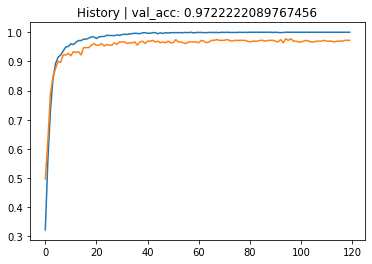

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("History | val_acc: "+str(history.history['val_acc'][len(history.history['val_acc'])-1]))
plt.show()

### Save the model

In [16]:
model_name = "mnist_model.h5"
model.save("models/" + model_name)

## Convert model for inference in the microcontroller

### Configuration and execution of the exporter

In [20]:
from tensorflow.keras.models import load_model
from sklearn.datasets import load_digits

from embedia.project_options import *
from embedia.project_generator import ProjectGenerator

OUTPUT_FOLDER = 'outputs/'
PROJECT_NAME  = 'arduino_mnist_float'
MODEL_FILE    = 'models/' + model_name

model = load_model(MODEL_FILE)

model._name = 'MNIST_Digits'

digits = load_digits()
example_number = 33
sample = digits.images[example_number]
comment= "number %d example for test" % digits.target[example_number]

options = ProjectOptions()

# options.project_type = ProjectType.ARDUINO
options.project_type = ProjectType.C
# options.project_type = ProjectType.CODEBLOCK
# options.project_type = ProjectType.CPP

options.data_type = ModelDataType.FLOAT
# options.data_type = ModelDataType.FIXED32
# options.data_type = ModelDataType.FIXED16
# options.data_type = ModelDataType.FIXED8

options.debug_mode = DebugMode.DISCARD
# options.debug_mode = DebugMode.DISABLED
# options.debug_mode = DebugMode.HEADERS
# options.debug_mode = DebugMode.DATA

options.example_data = sample
options.example_comment = comment

options.files = ProjectFiles.ALL
# options.files = {ProjectFiles.MAIN}
# options.files = {ProjectFiles.MODEL}
# options.files = {ProjectFiles.LIBRARY}

generator = ProjectGenerator()
generator.create_project(OUTPUT_FOLDER, PROJECT_NAME, model, options)

print("Project", PROJECT_NAME, "exported in", OUTPUT_FOLDER)
print("\n"+comment)

Project arduino_mnist_float exported in outputs/

number 5 example for test


### Test project generated in c language

In [29]:
if options.project_type == ProjectType.C:
    !cd outputs/C_mnist && gcc -o main main.c embedia.c mnist_digits_model.c -lm && ./main

Prediction class id: 5


### Download generated project

In [30]:
from google.colab import files

ruta = OUTPUT_FOLDER + PROJECT_NAME
!zip -r embedia_project.zip ruta
files.download('/content/EmbedIA/embedia_project.zip')

	zip warning: name not matched: ruta

zip error: Nothing to do! (try: zip -r embedia_project.zip . -i ruta)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>